In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import rustworkx as rx
from rustworkx.visualization import mpl_draw as draw_graph
import numpy as np
from scipy.optimize import minimize
from collections import defaultdict
from typing import Sequence
 
 
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import QAOAAnsatz
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
 
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import Session, EstimatorV2 as Estimator
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit_ibm_runtime.fake_provider import FakeWashingtonV2

from qiskit import QuantumCircuit



from qiskit.circuit.library import efficient_su2
from qiskit.circuit.library import TwoLocal
from qiskit.circuit.library import RealAmplitudes

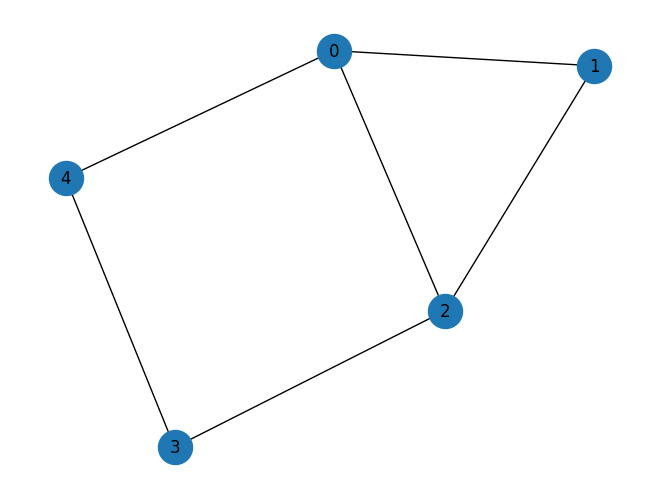

In [2]:
n_nodes = 5
 
graph = rx.PyGraph()
graph.add_nodes_from(np.arange(0, n_nodes, 1))
edge_list = [
    (0, 1, 1.0),
    (0, 2, 1.0),
    (0, 4, 1.0),
    (1, 2, 1.0),
    (2, 3, 1.0),
    (3, 4, 1.0),
]
graph.add_edges_from(edge_list)
draw_graph(graph, node_size=600, with_labels=True)

In [20]:
def build_max_cut_paulis(graph: rx.PyGraph) -> list[tuple[str, float]]:
    """Convert the graph to Pauli list.
 
    This function does the inverse of `build_max_cut_graph`
    """
    pauli_list = []
    for edge in list(graph.edge_list()):
        weight = graph.get_edge_data(edge[0], edge[1])
        pauli_list.append(("ZZ", [edge[0], edge[1]], weight))
    pauli_list.append(("Z", [0], 3))
    return pauli_list
 
 
max_cut_paulis = build_max_cut_paulis(graph)
print(max_cut_paulis)
cost_hamiltonian = SparsePauliOp.from_sparse_list(max_cut_paulis, n_nodes)
print("Cost Function Hamiltonian:", cost_hamiltonian)

[('ZZ', [0, 1], 1.0), ('ZZ', [0, 2], 1.0), ('ZZ', [0, 4], 1.0), ('ZZ', [1, 2], 1.0), ('ZZ', [2, 3], 1.0), ('ZZ', [3, 4], 1.0), ('Z', [0], 3)]
Cost Function Hamiltonian: SparsePauliOp(['IIIZZ', 'IIZIZ', 'ZIIIZ', 'IIZZI', 'IZZII', 'ZZIII', 'IIIIZ'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 3.+0.j])


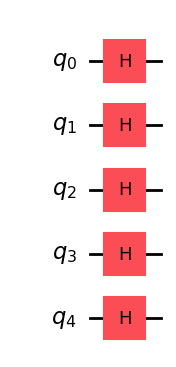

In [4]:
init_c = QuantumCircuit(5)
init_c.h(0)
init_c.h(1)
init_c.h(2)
init_c.h(3)
init_c.h(4)
init_c.draw("mpl")

In [ ]:
# Ansatz creation
ans = "QAUA"

if ans == "efficient":
    ansatz = efficient_su2(n_nodes, reps=2)
elif ans == "twolocal":
    ansatz = TwoLocal(n_nodes, rotation_blocks=['ry', 'rz'], entanglement_blocks='cx', entanglement='linear', reps=1)
elif ans == "realamplitudes":
    ansatz = RealAmplitudes(n_nodes, entanglement='linear', reps=1)
elif ans == "QAUA":
    ansatz = QAOAAnsatz(cost_operator=cost_hamiltonian, initial_state=init_c, reps=2)

ansatz.measure_all()

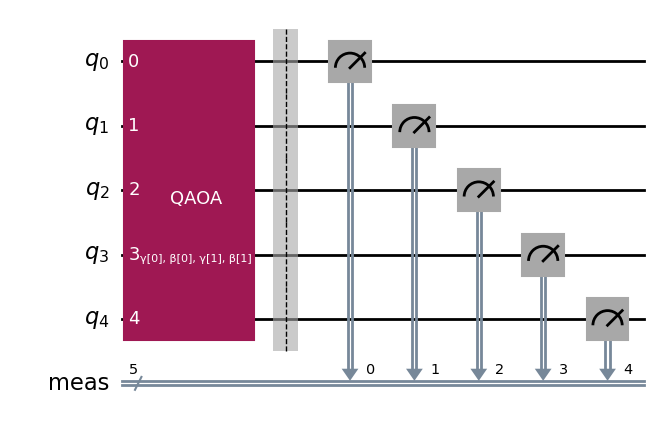

In [6]:
ansatz.draw("mpl")

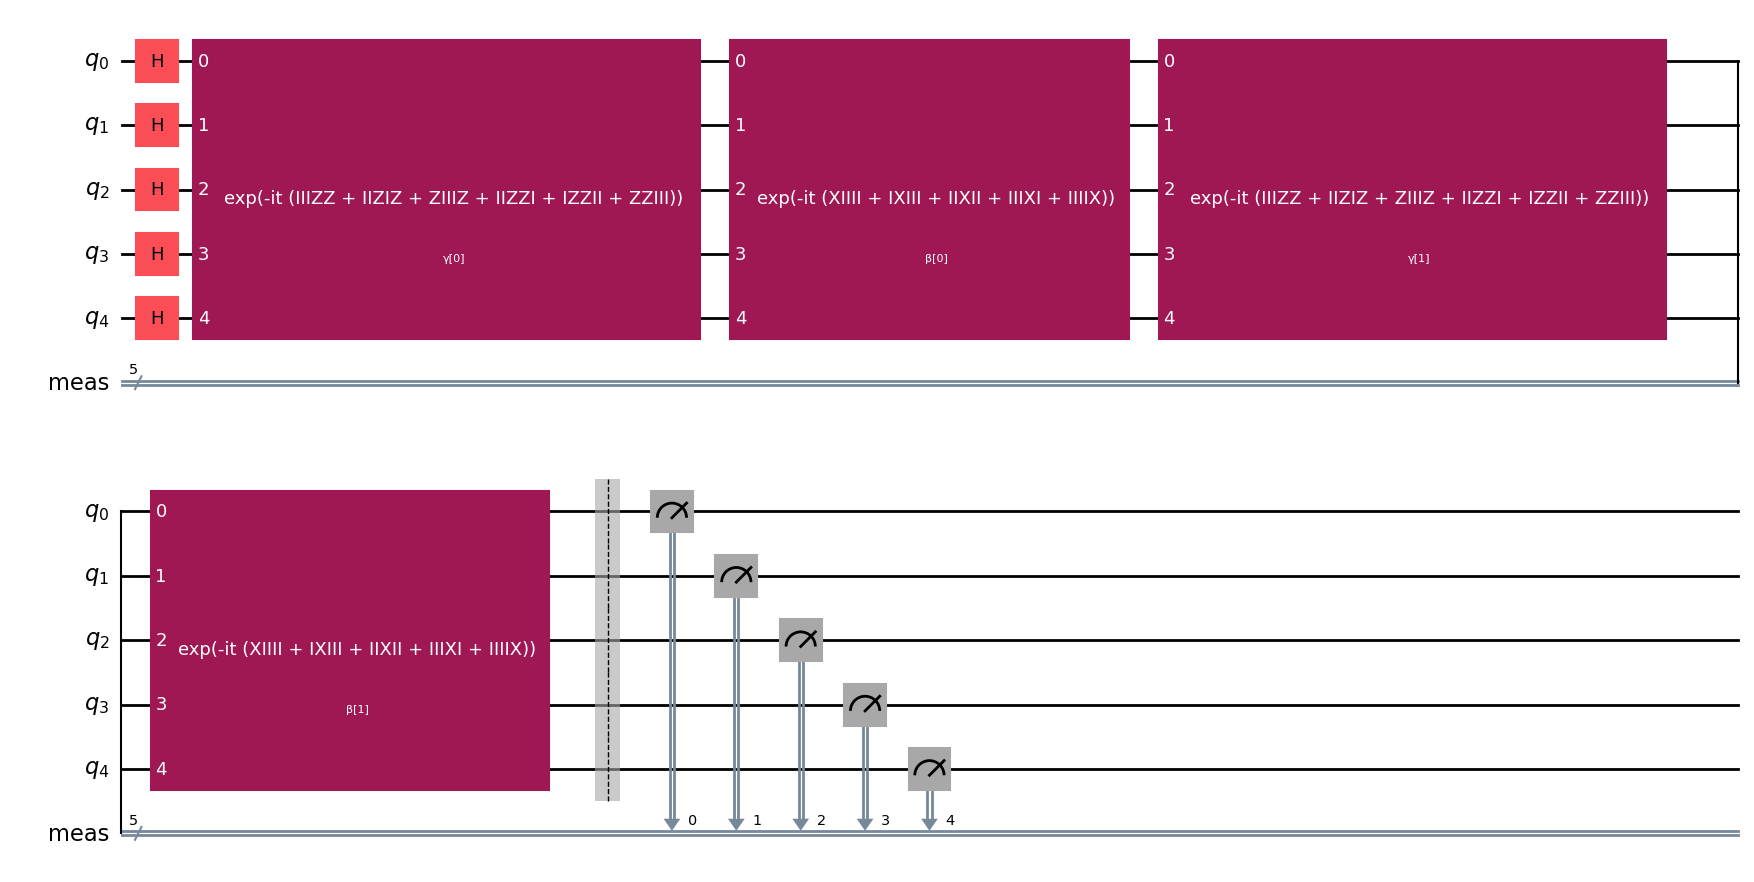

In [7]:
ansatz.decompose().draw("mpl")

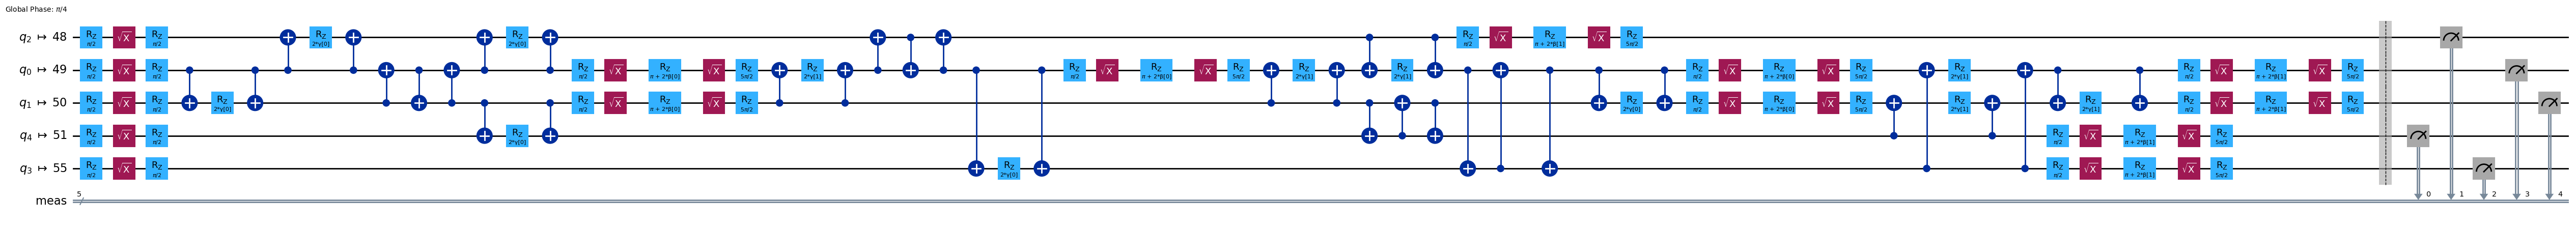

In [8]:
backend = FakeWashingtonV2()


 
# Create pass manager for transpilation
pm = generate_preset_pass_manager(optimization_level=3, backend=backend)
 
candidate_circuit = pm.run(ansatz)
candidate_circuit.draw("mpl", fold=False, idle_wires=False)

In [9]:
initial_gamma = np.pi
initial_beta = np.pi / 2
init_params = np.random.rand(ansatz.num_parameters) * 2 * np.pi

In [10]:
objective_func_vals = []  # Global variable

In [11]:
def cost_func_estimator(params, ansatz, hamiltonian, estimator):
    # transform the observable defined on virtual qubits to
    # an observable defined on all physical qubits
    isa_hamiltonian = hamiltonian.apply_layout(ansatz.layout)
 
    pub = (ansatz, isa_hamiltonian, params)
    job = estimator.run([pub])
 
    results = job.result()[0]
    cost = results.data.evs
 
    objective_func_vals.append(cost)
 
    return cost

In [12]:

with Session(backend=backend) as session:
    # If using qiskit-ibm-runtime<0.24.0, change `mode=` to `session=`
    estimator = Estimator(mode=session)
    estimator.options.default_shots = 1000
 
    # Set simple error suppression/mitigation options
    #estimator.options.dynamical_decoupling.enable = True
    #estimator.options.dynamical_decoupling.sequence_type = "XY4"
    #estimator.options.twirling.enable_gates = True
    #estimator.options.twirling.num_randomizations = "auto"
 
    result = minimize(
        cost_func_estimator,
        init_params,
        args=(candidate_circuit, cost_hamiltonian, estimator),
        method="COBYLA",
        tol=1e-2,
    )
    print(result)

 message: Return from COBYLA because the trust region radius reaches its lower bound.
 success: True
  status: 0
     fun: -1.5864135864135862
       x: [ 3.455e+00  1.911e+00  2.761e+00  1.705e+00]
    nfev: 32
   maxcv: 0.0


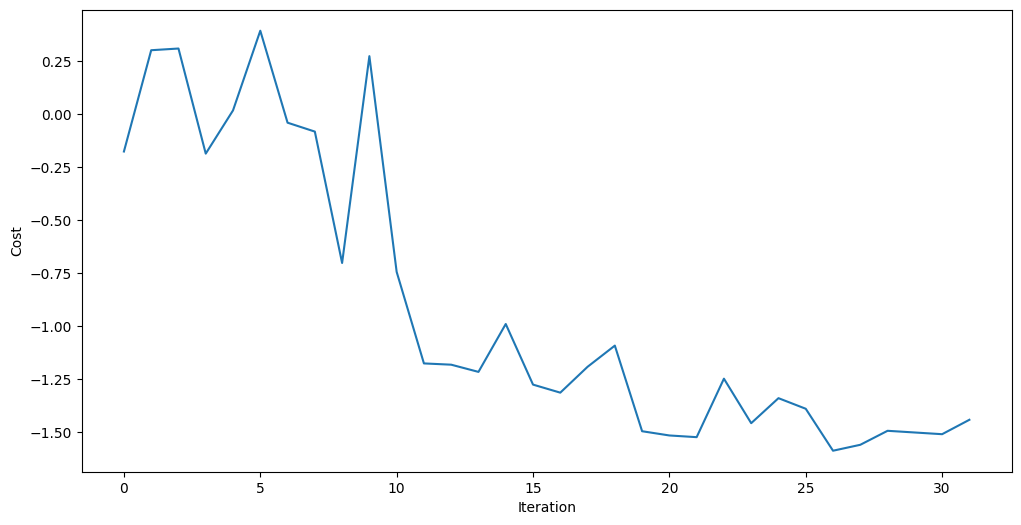

In [13]:
plt.figure(figsize=(12, 6))
plt.plot(objective_func_vals)
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.show()

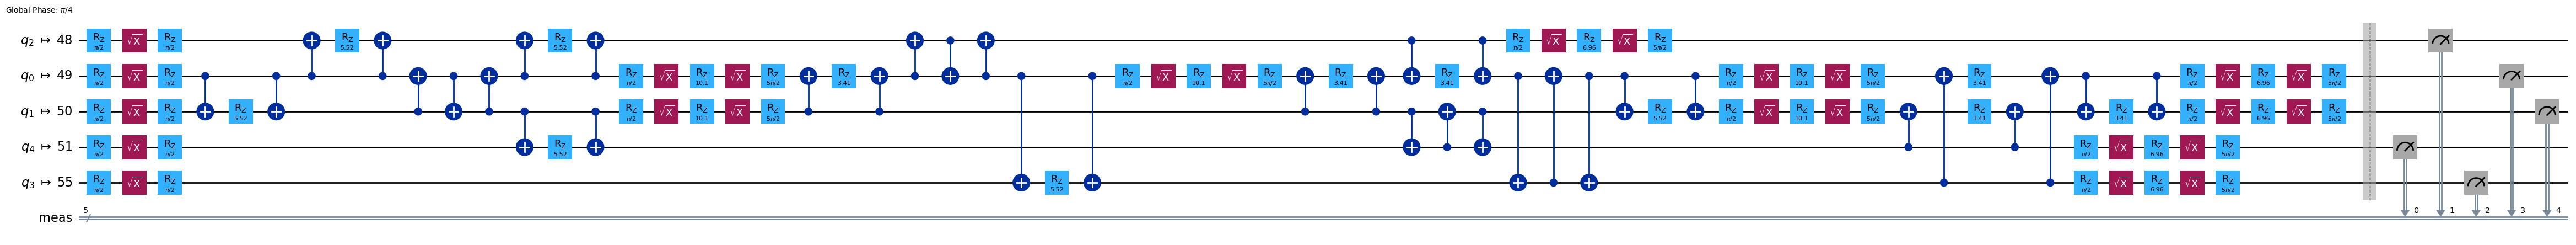

In [14]:
optimized_circuit = candidate_circuit.assign_parameters(result.x)
optimized_circuit.draw("mpl", fold=False, idle_wires=False)

In [15]:
# If using qiskit-ibm-runtime<0.24.0, change `mode=` to `backend=`
sampler = Sampler(mode=backend)
sampler.options.default_shots = 10000
 
# Set simple error suppression/mitigation options
#sampler.options.dynamical_decoupling.enable = True
#sampler.options.dynamical_decoupling.sequence_type = "XY4"
#sampler.options.twirling.enable_gates = True
#sampler.options.twirling.num_randomizations = "auto"
 
pub = (optimized_circuit,)
job = sampler.run([pub], shots=int(1e4))
counts_int = job.result()[0].data.meas.get_int_counts()
counts_bin = job.result()[0].data.meas.get_counts()
shots = sum(counts_int.values())
final_distribution_int = {key: val / shots for key, val in counts_int.items()}
final_distribution_bin = {key: val / shots for key, val in counts_bin.items()}
print(final_distribution_int)

{18: 0.0456, 30: 0.0208, 13: 0.059, 22: 0.0545, 26: 0.1166, 0: 0.0036, 2: 0.0109, 27: 0.0218, 5: 0.1234, 23: 0.0131, 31: 0.0063, 6: 0.0196, 17: 0.0151, 20: 0.0517, 10: 0.0481, 11: 0.0631, 15: 0.0143, 9: 0.0534, 24: 0.0157, 8: 0.0093, 7: 0.0239, 28: 0.0166, 14: 0.0174, 19: 0.0168, 29: 0.015, 12: 0.0133, 21: 0.051, 3: 0.0173, 1: 0.018, 16: 0.0108, 25: 0.0172, 4: 0.0168}


In [16]:
# auxiliary functions to sample most likely bitstring
def to_bitstring(integer, num_bits):
    result = np.binary_repr(integer, width=num_bits)
    return [int(digit) for digit in result]
 
 
keys = list(final_distribution_int.keys())
values = list(final_distribution_int.values())
most_likely = keys[np.argmax(np.abs(values))]
most_likely_bitstring = to_bitstring(most_likely, len(graph))
most_likely_bitstring.reverse()
 
print("Result bitstring:", most_likely_bitstring)

Result bitstring: [1, 0, 1, 0, 0]


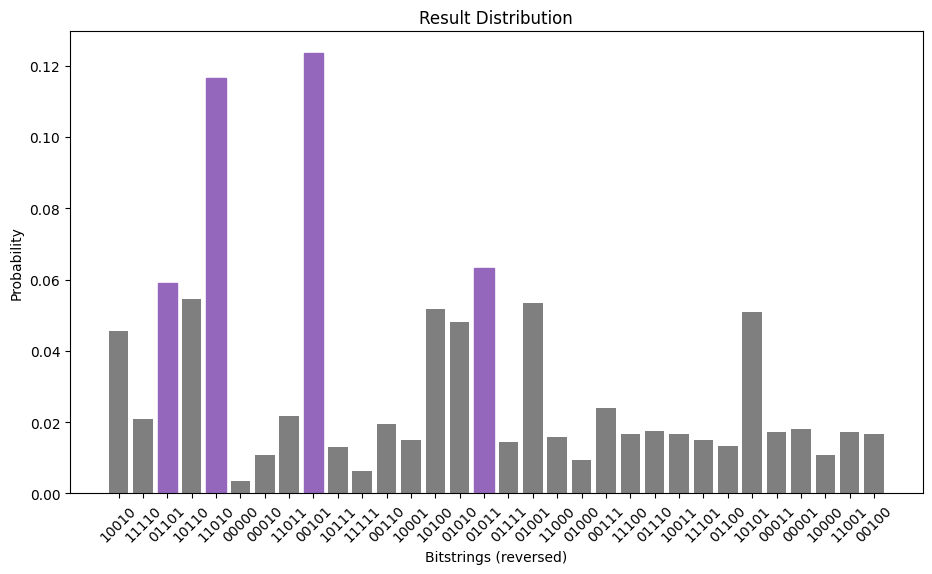

In [17]:
matplotlib.rcParams.update({"font.size": 10})
final_bits = final_distribution_bin
values = np.abs(list(final_bits.values()))
top_4_values = sorted(values, reverse=True)[:4]
positions = []
for value in top_4_values:
    positions.append(np.where(values == value)[0])
fig = plt.figure(figsize=(11, 6))
ax = fig.add_subplot(1, 1, 1)
plt.xticks(rotation=45)
plt.title("Result Distribution")
plt.xlabel("Bitstrings (reversed)")
plt.ylabel("Probability")
ax.bar(list(final_bits.keys()), list(final_bits.values()), color="tab:grey")
for p in positions:
    ax.get_children()[int(p[0])].set_color("tab:purple")
plt.show()